In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from torchvision import datasets, transforms

In [3]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['target'] = cancer['target']
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [8]:
data = torch.from_numpy(cancer_df.values).float()
x = data[:, :-1]
y = data[:, -1:]
x.shape, y.shape

(torch.Size([569, 30]), torch.Size([569, 1]))

In [9]:
ratios = [0.6, 0.2, 0.2]
train_cnt = int(data.shape[0] * ratios[0])
valid_cnt = int(data.shape[0] * ratios[1])
test_cnt = data.shape[0] - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[341, 113, 115]

In [10]:
indices = torch.randperm(data.shape[0])
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))
for x_i, y_i in zip(x, y):
    print(x_i.shape, y_i.shape)

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [11]:
scaler = StandardScaler().fit(x[0].numpy())
for i in range(3):
    x[i] = torch.from_numpy(scaler.transform(x[i].numpy())).float()
x

[tensor([[ 0.1328,  0.8059,  0.1834,  ..., -0.0322, -1.0520, -0.1886],
         [ 1.8310, -0.3295,  1.6859,  ...,  1.1274, -0.2314,  0.2962],
         [-0.1170,  0.3781, -0.0713,  ...,  0.6605,  0.5124,  1.7040],
         ...,
         [ 1.2290,  0.6278,  1.1633,  ...,  0.3886,  0.3673, -0.4012],
         [-0.2108,  2.6650, -0.2301,  ..., -0.5370, -1.1554, -0.3662],
         [ 0.4622,  0.0058,  0.6242,  ...,  1.5498,  2.2619,  1.1588]]),
 tensor([[-0.7986, -0.0358, -0.8285,  ..., -0.6602, -0.8151, -0.9243],
         [ 0.2862,  2.4546,  0.1966,  ..., -0.7195,  0.5741, -1.1813],
         [-0.2619, -0.7804, -0.3236,  ..., -1.3454, -0.3965,  0.0171],
         ...,
         [-0.6026,  2.0892, -0.6240,  ..., -0.6364, -0.7368, -0.0860],
         [-0.3527,  2.2488, -0.3882,  ..., -0.7321, -0.8618, -0.5999],
         [-0.0716,  0.3480, -0.0890,  ..., -0.6780, -1.0670,  0.0749]]),
 tensor([[-0.5515, -0.3133, -0.5820,  ..., -0.8259, -1.1037, -0.5276],
         [ 1.5811,  0.4752,  1.5665,  ...,  2

In [18]:
model = nn.Sequential(
    nn.Linear(x[0].shape[1], 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(0.01),
    nn.Linear(20, 15),
    nn.LeakyReLU(0.01),
    nn.Linear(15, 10),
    nn.LeakyReLU(0.01),
    nn.Linear(10, 5),
    nn.LeakyReLU(0.01),
    nn.Linear(5, y[0].shape[1]),
    nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=30, out_features=25, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=25, out_features=20, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=20, out_features=15, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=15, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=5, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=5, out_features=1, bias=True)
  (11): Sigmoid()
)


In [19]:
opt = optim.Adam(model.parameters())

In [20]:
n_epochs = 10000
batch_size = 64
print_interval = 20
early_stop = 100

In [21]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [22]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].shape[0])
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += float(loss)
    
    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            valid_loss += float(loss)
            y_hat += [y_hat_i]
        
        valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break
    
    if (i+1) % print_interval == 0:
        print(f'Epoch {i+1}: train loss={train_loss:.4f}, valid loss={valid_loss:.4f}, lowest loss={lowest_loss:.4f}')

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4f}')
model.load_state_dict(best_model)

Epoch 20: train loss=0.3390, valid loss=0.2999, lowest loss=0.2999
Epoch 40: train loss=0.0379, valid loss=0.0272, lowest loss=0.0272
Epoch 60: train loss=0.0267, valid loss=0.0526, lowest loss=0.0267
Epoch 80: train loss=0.0200, valid loss=0.0894, lowest loss=0.0267
Epoch 100: train loss=0.0112, valid loss=0.1296, lowest loss=0.0267
Epoch 120: train loss=0.0010, valid loss=0.8107, lowest loss=0.0267
Epoch 140: train loss=0.0003, valid loss=0.8152, lowest loss=0.0267
There is no improvement during last 100 epochs.
The best validation loss from epoch 44: 0.0267


<All keys matched successfully>

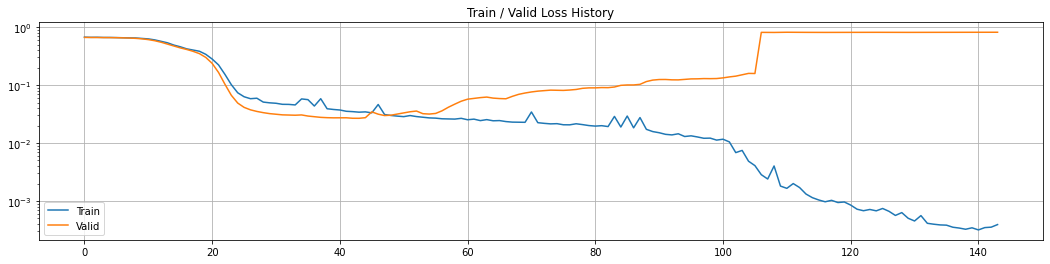

In [23]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [24]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]
    
    test_loss = test_loss / len(x_)

y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4f}')
print(f'Valid loss: {sorted_history[0][1]:.4f}')
print(f'Test loss: {test_loss:.4f}')

Train loss: 0.0341
Valid loss: 0.0267
Test loss: 0.0841


In [25]:
correct_cnt = (y[2] == (y_hat > 0.5)).sum()
total_cnt = y[2].shape[0]

print(f'Test Accuracy: {correct_cnt / total_cnt:.2%}')

Test Accuracy: 98.26%


In [29]:
df = pd.DataFrame(torch.concat([y[2], y_hat > 0.5], dim=1).detach().numpy(), columns=['y', 'y_hat'])
df

,y,y_hat
0,1.0,1.0
1,0.0,0.0
2,1.0,1.0
3,0.0,0.0
4,0.0,0.0
...,...,...
110,1.0,1.0
111,1.0,1.0
112,0.0,0.0
113,0.0,0.0


In [30]:
roc_auc_score(df.values[:, 0], df.values[:, 1])

0.9787234042553192